# Model Training 
This is the code is the training code for ML-based approach in intrusion detection. It was modified from notebook provided by "[**Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection**](https://arxiv.org/pdf/2409.03141)".

Please also cite:
L. Yang and A. Shami, “Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection,” in Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber ’24), 2024 ACM SIGSAC Conference on Computer and Communications Security (CCS’24), 2024, pp. 1–11. doi: 10.1145/3689933.3690833.

```
@INPROCEEDINGS{3690833,
  author={Yang, Li and Shami, Abdallah},
  title = {Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection},
  booktitle = {Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber '24), ACM Conference on Computer and Communications Security (CCS) 2024},
  year = {2024},
  address = {Salt Lake City, UT, USA},
  pages = {1-11},
  doi = {10.1145/3689933.3690833}
}
```

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder 

In [3]:
CHECKPOINT_OUTPUT = "./models"

## Dataset 1: CICIDS2017
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of CICIDS2017 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.


### Load data

In [4]:
# Read the dataset
df = pd.read_csv('../../datasets/output/train_final.csv', parse_dates=['Timestamp'])

In [5]:
df = df.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Old Index', 'Fwd TCP Retrans. Count', 'Bwd TCP Retrans. Count', 'Total TCP Retrans. Count', 'Total Connection Flow Time', 'ICMP Type', 'ICMP Code'], axis=1)

In [6]:
df['Label'].value_counts()

Label
Benign       484847
Portscan     127232
Slowloris      4565
Name: count, dtype: int64

In [7]:
df['Label'] = df['Label'].map({
    "Slowloris": "Not Portscan",
    "Portscan": "Portscan",
    "Benign": "Not Portscan"
})

In [8]:
df['Label'].value_counts()

Label
Not Portscan    489412
Portscan        127232
Name: count, dtype: int64

### Data pre-processing

In [9]:
# Encode the dataset
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

In [10]:
df['Label'].value_counts()

Label
0    489412
1    127232
Name: count, dtype: int64

In [11]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Portscan', 'Portscan'])

array([0, 1])

In [12]:
df.isnull().any().any()

False

In [13]:
df.isna().any().any()

False

In [14]:
X = df.drop(['Label'],axis=1) 
y = df['Label'].values.reshape(-1,1)
y=np.ravel(y)

In [15]:
labelencoder.classes_

array(['Not Portscan', 'Portscan'], dtype='<U12')

## Cross Validation Preparation

In [16]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

splits = []
for train_index, test_index in skf.split(X, y):
    splits.append((train_index, test_index))

In [17]:
i = 0
for train_index, test_index in splits:
    pd.Series(train_index).to_csv(f"{CHECKPOINT_OUTPUT}/imbalance_train_idx_{i}.csv", index=False)
    pd.Series(test_index).to_csv(f"{CHECKPOINT_OUTPUT}/imbalance_test_idx_{i}.csv", index=False)
    i += 1

## Data Balancing by Proposed TVAE-based Method

In [18]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer

def balance_data_with_tvae(df, X_train, y_train):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)

    y_train = pd.Series(y_train)

    # Identify the average number of samples per class
    average_samples = y_train.value_counts().mean()

    # Identify minority classes with less than half the average number of samples
    minority_classes = y_train.value_counts()
    minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

    # Prepare an empty DataFrame to collect synthetic data
    synthetic_data = pd.DataFrame()

    y_train.index = X_train.index

    # Generating synthetic samples for each minority class using TVAE
    for cls in minority_classes:
        cls_samples = X_train[y_train == cls]
        num_samples_needed = int(average_samples - len(cls_samples))
        
        # Initialize the TVAE model with detected metadata
        tvaegan = TVAESynthesizer(metadata=metadata, cuda=True, verbose=True)
        
        # Fit the TVAE model on the minority class samples
        tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training
        
        # Generate synthetic instances to match the average class sample size
        new_samples = tvaegan.sample(num_samples_needed)
        
        # Append the new synthetic instances to the synthetic data list
        synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)
    
    # Concatenate the original and synthetic data to form a balanced dataset
    balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

    # Display the new distribution of labels in the balanced dataset
    print(balanced_data['Label'].value_counts())

    # Prepare the balanced dataset for model training
    return (balanced_data.drop(['Label'], axis=1), balanced_data['Label'])

In [19]:
X_train_full_balanced, y_train_full_balanced = balance_data_with_tvae(df, X, y)
X_train_full_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/X_train_full_balanced.pkl")
y_train_full_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/y_train_full_balanced.pkl")

Loss: -603.644: 100%|██████████| 300/300 [36:30<00:00,  7.30s/it]


Label
0    489412
1    308322
Name: count, dtype: int64


In [20]:
balanced_splits = []
i = 0
for train_idx, _ in splits:
    X_train_balanced, y_train_balanced = balance_data_with_tvae(df, X.iloc[train_idx], y[train_idx])
    X_train_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/X_train_balanced_{i}.pkl")
    y_train_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/y_train_balanced_{i}.pkl")
    balanced_splits.append((X_train_balanced, y_train_balanced))
    i += 1

Loss: -602.474: 100%|██████████| 300/300 [24:49<00:00,  4.96s/it]


Label
0    326274
1    205548
Name: count, dtype: int64


Loss: -569.833: 100%|██████████| 300/300 [24:24<00:00,  4.88s/it]


Label
0    326275
1    205548
Name: count, dtype: int64


Loss: -599.194: 100%|██████████| 300/300 [24:17<00:00,  4.86s/it]


Label
0    326275
1    205548
Name: count, dtype: int64


In [21]:
for train_index, test_index in splits:
    print(pd.Series(y[train_index]).value_counts(dropna=False))
    print(pd.Series(y[test_index]).value_counts(dropna=False))

0    326274
1     84822
Name: count, dtype: int64
0    163138
1     42410
Name: count, dtype: int64
0    326275
1     84821
Name: count, dtype: int64
0    163137
1     42411
Name: count, dtype: int64
0    326275
1     84821
Name: count, dtype: int64
0    163137
1     42411
Name: count, dtype: int64


In [22]:
for i in range(3):
    test_idx = splits[i][1]
    X.iloc[test_idx].to_pickle(f"{CHECKPOINT_OUTPUT}/X_validation_{i}.pkl")
    pd.Series(y[test_idx]).to_pickle(f"{CHECKPOINT_OUTPUT}/y_validation_{i}.pkl")

## Checkpoint

In [4]:
X_train_full_balanced = pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_train_full_balanced.pkl")
y_train_full_balanced = pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_train_full_balanced.pkl")

In [5]:
balanced_train_splits = []
for i in range(3):
    balanced_train_splits.append((pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_train_balanced_{i}.pkl"), pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_train_balanced_{i}.pkl")))

In [6]:
val_splits = []
for i in range(3):
    val_splits.append((pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_validation_{i}.pkl"), pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_validation_{i}.pkl")))

## Machine learning model training (for feature selection)

### Training six base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


In [7]:
import joblib
MODEL_OUTPUT_PREFS = "./models/prefs"

In [8]:
from sklearn.metrics import f1_score

def cross_val_f1_macro(clf):
    results = []
    for i in range(3):
        X_train_balanced, y_train_balanced = balanced_train_splits[i]
        X_val, y_val = val_splits[i]
        clf.fit(X_train_balanced, y_train_balanced)
        y_pred = clf.predict(X_val)
        results.append(f1_score(y_val, y_pred, average='macro'))
    return results

#### DT

In [9]:
import time
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_f1_macro(dt)

start = time.time()
dt.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

Training time:  8.369036436080933
Cross-Validation scores:  [0.9999628645667462, 0.999940582788416, 0.9999925729133492]
Mean of Cross-Validation scores:  0.9999653400895038


In [10]:
joblib.dump(dt, f"{MODEL_OUTPUT_PREFS}/dt.pkl")

['./models/prefs/dt.pkl']

#### RF

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, n_jobs=12)
rf_scores = cross_val_f1_macro(rf)

start = time.time()
rf.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

Training time:  16.932379245758057
Cross-Validation scores:  [0.9999925727837531, 0.9999628632707513, 0.9999851459562896]
Mean of Cross-Validation scores:  0.9999801940035979


In [12]:
joblib.dump(rf, f"{MODEL_OUTPUT_PREFS}/rf.pkl")

['./models/prefs/rf.pkl']

#### ET

In [13]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=12)
et_scores = cross_val_f1_macro(et)

# calculate the training time
start = time.time()
et.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

Training time:  14.444921255111694
Cross-Validation scores:  [1.0, 0.9999777183512593, 0.9999925729133492]
Mean of Cross-Validation scores:  0.9999900970882027


In [14]:
joblib.dump(et, f"{MODEL_OUTPUT_PREFS}/et.pkl")

['./models/prefs/et.pkl']

#### XGBoost

In [15]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=12)
xg_scores = cross_val_f1_macro(xg)

# calculate the training time
start = time.time()
xg.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

Training time:  2.1761176586151123
Cross-Validation scores:  [0.9999702919125792, 0.9999628632707513, 0.9999851459562896]
Mean of Cross-Validation scores:  0.99997276704654


In [16]:
joblib.dump(xg, f"{MODEL_OUTPUT_PREFS}/xg.pkl")

['./models/prefs/xg.pkl']

#### LightGBM

In [17]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_f1_macro(lgbm)

# calculate the training time
start = time.time()
lgbm.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16247
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 326275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

In [18]:
joblib.dump(lgbm, f"{MODEL_OUTPUT_PREFS}/lgbm.pkl")

['./models/prefs/lgbm.pkl']

#### Catboost

In [19]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False, thread_count=12)
cat_scores = cross_val_f1_macro(cat)

# calculate the training time
start = time.time()
cat.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

Training time:  45.6752073764801
Cross-Validation scores:  [0.9999777187400477, 0.9999480094862716, 0.9999702919125792]
Mean of Cross-Validation scores:  0.9999653400462996


In [20]:
joblib.dump(cat, f"{MODEL_OUTPUT_PREFS}/cat.pkl")

['./models/prefs/cat.pkl']

In [21]:
import gc
gc.collect()

20

## Model selection

In [22]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)
}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [23]:
base_model_performance

{'dt': 0.9999653400895038,
 'rf': 0.9999801940035979,
 'et': 0.9999900970882027,
 'xg': 0.99997276704654,
 'lgbm': 0.9999702915669945,
 'cat': 0.9999653400462996}

In [24]:
ranked_models

['et', 'rf', 'xg', 'lgbm', 'dt', 'cat']

In [25]:
top_3_models

['et', 'rf', 'xg']

## Automated Feature Selection

In [26]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [27]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [28]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature = X_train_full_balanced.columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.3632, 'Flow Duration'), (0.1212, 'Bwd RST Flags'), (0.0691, 'RST Flag Count'), (0.0362, 'Packet Length Mean'), (0.0349, 'Protocol'), (0.0342, 'Fwd Seg Size Min'), (0.0334, 'Average Packet Size'), (0.0311, 'Flow IAT Max'), (0.0227, 'Fwd Packet Length Max'), (0.0211, 'Packet Length Max'), (0.0158, 'Bwd Packet Length Max'), (0.0155, 'Fwd Segment Size Avg'), (0.0155, 'Bwd Segment Size Avg'), (0.0138, 'Fwd Act Data Pkts'), (0.0136, 'Total Length of Fwd Packet'), (0.013, 'Bwd Packet Length Mean'), (0.0129, 'FWD Init Win Bytes'), (0.0115, 'Total Length of Bwd Packet'), (0.0115, 'Bwd Act Data Pkts'), (0.0102, 'Packet Length Std'), (0.0099, 'Fwd Packet Length Mean'), (0.0085, 'Bwd Packets/s'), (0.0061, 'Flow IAT Mean'), (0.0055, 'SYN Flag Count'), (0.0052, 'FIN Flag Count'), (0.0045, 'Fwd IAT Total'), (0.0043, 'Total Fwd Packet'), (0.0042, 'Bwd Init Win Bytes'), (0.0036, 'Bwd Packet Length Min'), (0.0033, 'Fwd RST Flags'), (0.003, 'Flow IAT Std'), (0.0029, 'F

In [29]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break

In [30]:
print(fs)

['Flow Duration', 'Bwd RST Flags', 'RST Flag Count', 'Packet Length Mean', 'Protocol', 'Fwd Seg Size Min', 'Average Packet Size', 'Flow IAT Max', 'Fwd Packet Length Max', 'Packet Length Max', 'Bwd Packet Length Max', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Act Data Pkts', 'Total Length of Fwd Packet', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Packet Length Std']


In [ ]:
fs = ['Flow Duration', 'Bwd RST Flags', 'RST Flag Count', 'Packet Length Mean', 'Protocol', 'Fwd Seg Size Min', 'Average Packet Size', 'Flow IAT Max', 'Fwd Packet Length Max', 'Packet Length Max', 'Bwd Packet Length Max', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Act Data Pkts', 'Total Length of Fwd Packet', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Packet Length Std']

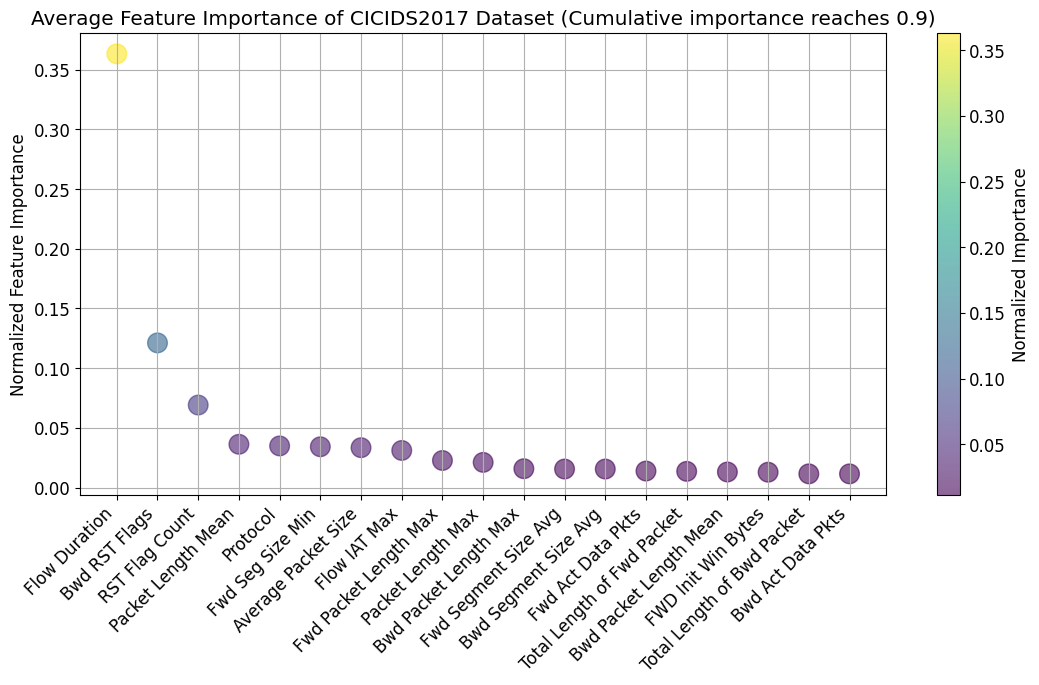

In [31]:
# Plot the feature importance of the top-3 models
plt.rcParams.update({'font.size': 12})

# Create a DataFrame for easier plotting
features = pd.DataFrame({
    'Feature': X_train_full_balanced.columns,
    'Importance': avg_feature
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Calculate cumulative importance and filter features
features['Cumulative'] = features['Importance'].cumsum()
filtered_features = features[features['Cumulative'] <= 0.9]

# Plotting
plt.figure(figsize=(13, 6))
scatter = plt.scatter(x='Feature', y='Importance', s=200, c='Importance', cmap='viridis', alpha=0.6, data=filtered_features)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Average Feature Importance of CICIDS2017 Dataset (Cumulative importance reaches 0.9)')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.show()

In [32]:
num_features_original = len(X_train_full_balanced.columns)
num_features_selected = len(fs)

print(f"Features before selection: {num_features_original}")
print(f"Features after selection: {num_features_selected}")

Features before selection: 81
Features after selection: 20


In [33]:
X_train_full_balanced_fs = X_train_full_balanced[fs]

In [34]:
balanced_train_splits_fs = []
val_splits_fs = []
for i in range(3):
    X_train_balanced, y_train_balanced = balanced_train_splits[i]
    X_val, y_val = val_splits[i]
    balanced_train_splits_fs.append((X_train_balanced[fs], y_train_balanced))
    val_splits_fs.append((X_val[fs], y_val))

# Testing

## Machine learning model training

### Training six base learners: 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

In [35]:
POST_FS_MODEL_OUTPUT = "./models/postfs"

In [36]:
def cross_val_f1_macro_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]
        clf.fit(X_train_balanced_fs, y_train_balanced_fs)
        y_pred_fs = clf.predict(X_val_fs)
        results.append(f1_score(y_val_fs, y_pred_fs, average='macro'))
    return results

### DT

In [37]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_f1_macro_fs(dt)

start = time.time()
dt.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

Training time:  2.2391297817230225
Cross-Validation scores:  [0.999970291394208, 0.9999554363137151, 1.0]
Mean of Cross-Validation scores:  0.9999752425693077


In [38]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_untuned.pkl")

['./models/postfs/dt_untuned.pkl']

In [39]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 20/20 [01:46<00:00,  5.34s/trial, best loss: -0.9999702908757951]
Decision Tree: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 27, 'min_samples_leaf': 1, 'min_samples_split': 4}


DecisionTreeClassifier(criterion='entropy', max_depth=27, min_samples_split=4,
                       random_state=0)

In [ ]:
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    # 'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    # 'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 1, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
} # 99998

In [69]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 20/20 [01:42<00:00,  5.12s/trial, best loss: -0.9999801939172066]
Decision Tree: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 8}


DecisionTreeClassifier(max_depth=10, min_samples_split=8, random_state=0)

In [70]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_tuned.pkl")

['./models/postfs/dt_tuned.pkl']

In [72]:
dt_score = 0.9999801939172066 # taken from printed best loss above

### RF

In [41]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_f1_macro_fs(rf)

# calculate the training time
start = time.time()
rf.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

Training time:  12.090925693511963
Cross-Validation scores:  [0.9999851456971041, 0.9999628632707513, 0.9999851459562896]
Mean of Cross-Validation scores:  0.9999777183080484


In [42]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_untuned.pkl")

['./models/postfs/rf_untuned.pkl']

In [43]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 80, 150, 5),
    'max_depth': hp.quniform('max_depth', 5, 40, 3),
    "max_features":hp.quniform('max_features', 1, 7, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **best)
rf.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 20/20 [09:18<00:00, 27.90s/trial, best loss: -0.9999826703039271]
Random Forest: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 18, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 110}


RandomForestClassifier(max_depth=18, max_features=2, min_samples_leaf=2,
                       min_samples_split=6, n_estimators=110, random_state=0)

In [44]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_tuned.pkl")

['./models/postfs/rf_tuned.pkl']

In [73]:
rf_score = 0.9999826703039271

In [45]:
import gc
gc.collect()

84

### ET

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=12)
et_scores = cross_val_f1_macro_fs(et)

# calculate the training time
start = time.time()
et.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

Training time:  10.452309370040894
Cross-Validation scores:  [0.9999925726541503, 0.9999851456971041, 1.0]
Mean of Cross-Validation scores:  0.9999925727837514


In [47]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_untuned.pkl")

['./models/postfs/et_untuned.pkl']

In [48]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **best)
et.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 20/20 [06:45<00:00, 20.26s/trial, best loss: -0.9999950485657013]
Extra Trees: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 47, 'max_features': 13, 'min_samples_leaf': 9, 'min_samples_split': 9, 'n_estimators': 86}


ExtraTreesClassifier(max_depth=47, max_features=13, min_samples_leaf=9,
                     min_samples_split=9, n_estimators=86, random_state=0)

In [74]:
et_score = 0.9999950485657013

In [49]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_tuned.pkl")

['./models/postfs/et_tuned.pkl']

In [50]:
import gc
gc.collect()

644

### XGBoost

In [51]:
import xgboost as xgb
import numpy as np

# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=12)
xg_scores = cross_val_f1_macro_fs(xg)

# calculate the training time
start = time.time()
xg.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

Training time:  0.9292008876800537
Cross-Validation scores:  [0.9999851456971041, 0.9999628632707513, 0.9999480113005711]
Mean of Cross-Validation scores:  0.9999653400894756


In [52]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_untuned.pkl")

['./models/postfs/xg_untuned.pkl']

In [53]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(eval_metric='mlogloss', random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 80, 150, 3),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 1),
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
xg = xgb.XGBClassifier(eval_metric='mlogloss', random_state=0, **best)
xg.fit(X_train_full_balanced_fs, y_train_full_balanced)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:58<00:00,  2.92s/trial, best loss: -0.9999702913941831]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.7052830507933698, 'max_depth': 9, 'n_estimators': 126}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.7052830507933698, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=126, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [75]:
xg_score = 0.9999702913941831

In [54]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_tuned.pkl")

['./models/postfs/xg_tuned.pkl']

### LightGBM

In [55]:
import lightgbm as lgb
import numpy as np

# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=12)
lgbm_scores = cross_val_f1_macro_fs(lgbm)

# calculate the training time
start = time.time()
lgbm.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 326275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

In [56]:
import joblib
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_untuned.pkl")

['./models/postfs/lgbm_untuned.pkl']

In [57]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **best)
lgbm.fit(X_train_full_balanced_fs, y_train_full_balanced)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3907                     
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

LGBMClassifier(learning_rate=0.6317848220716972, max_depth=42,
               min_child_samples=78, n_estimators=45, num_leaves=48,
               random_state=0)

In [58]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_tuned.pkl")

['./models/postfs/lgbm_tuned.pkl']

In [76]:
lgbm_score = 0.9999876210902504

### CatBoost

In [59]:
from catboost import CatBoostClassifier
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, thread_count=8, verbose=False)
cat_scores = cross_val_f1_macro_fs(cat)

# calculate the training time
start = time.time()
cat.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

Training time:  28.464436292648315
Cross-Validation scores:  [0.9999851456971041, 0.9999034394489232, 0.9999480103934447]
Mean of Cross-Validation scores:  0.9999455318464907


In [60]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_untuned.pkl")

['./models/postfs/cat_untuned.pkl']

In [61]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, thread_count=12, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, **best)
cat.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 20/20 [12:46<00:00, 38.35s/trial, best loss: -0.9999752428284762]
CatBoost: Hyperopt estimated optimum {'depth': 9, 'iterations': 900, 'learning_rate': 0.012156468414221001}


In [77]:
cat_score = 0.9999752428284762

In [62]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_tuned.pkl")

['./models/postfs/cat_tuned.pkl']

## Model selection

In [78]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': dt_score,
    'rf': rf_score,
    'et': et_score,
    'xg': xg_score,
    'lgbm': lgbm_score,
    'cat': cat_score,

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [79]:
base_model_performance

{'dt': 0.9999801939172066,
 'rf': 0.9999826703039271,
 'et': 0.9999950485657013,
 'xg': 0.9999702913941831,
 'lgbm': 0.9999876210902504,
 'cat': 0.9999752428284762}

In [80]:
ranked_models

['et', 'lgbm', 'rf', 'dt', 'cat', 'xg']

In [81]:
top_3_models

['et', 'lgbm', 'rf']

In [82]:
def transform_stk1(x_val_stk):
    y_model_1 = et.predict(x_val_stk).reshape(-1, 1)
    y_model_2 = lgbm.predict(x_val_stk).reshape(-1, 1)
    y_model_3 = rf.predict(x_val_stk).reshape(-1, 1)
    return np.concatenate([y_model_1, y_model_2, y_model_3], axis=1)

def transform_stk2(x_val_stk):
    y_proba_1 = et.predict_proba(x_val_stk)
    y_proba_2 = lgbm.predict_proba(x_val_stk)
    y_proba_3 = rf.predict_proba(x_val_stk)
    return np.concatenate([y_proba_1, y_proba_2, y_proba_3], axis=1)

def transform_stk3(x_val_stk):
    y_model_1 = et.predict(x_val_stk).reshape(-1, 1)
    y_model_2 = lgbm.predict(x_val_stk).reshape(-1, 1)
    y_model_3 = rf.predict(x_val_stk).reshape(-1, 1)
    y_proba_1 = et.predict_proba(x_val_stk)
    y_proba_2 = lgbm.predict_proba(x_val_stk)
    y_proba_3 = rf.predict_proba(x_val_stk)
    return np.concatenate([y_model_1, y_model_2, y_model_3] + [y_proba_1, y_proba_2, y_proba_3], axis=1)

In [83]:
def cross_val_f1_macro_stk1_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]

        x_train_tf = transform_stk1(X_train_balanced_fs)
        x_val_tf = transform_stk1(X_val_fs)

        clf.fit(x_train_tf, y_train_balanced_fs)
        y_pred_fs = clf.predict(x_val_tf)
        results.append(f1_score(y_val_fs, y_pred_fs, average='macro'))
    return results

def cross_val_f1_macro_stk2_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]

        x_train_tf = transform_stk2(X_train_balanced_fs)
        x_val_tf = transform_stk2(X_val_fs)

        clf.fit(x_train_tf, y_train_balanced_fs)
        y_pred_fs = clf.predict(x_val_tf)
        results.append(f1_score(y_val_fs, y_pred_fs, average='macro'))
    return results

def cross_val_f1_macro_stk3_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]

        x_train_tf = transform_stk3(X_train_balanced_fs)
        x_val_tf = transform_stk3(X_val_fs)

        clf.fit(x_train_tf, y_train_balanced_fs)
        y_pred_fs = clf.predict(x_val_tf)
        results.append(f1_score(y_val_fs, y_pred_fs, average='macro'))
    return results

In [84]:
# Ensemble method 1: traditional stacking

stk1 = lgb.LGBMClassifier(random_state=0)
stk1_scores = cross_val_f1_macro_stk1_fs(stk1)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', stk1_scores)
print('Mean of Cross-Validation scores: ', np.mean(stk1_scores))

x_stk1 = transform_stk1(X_train_full_balanced_fs)
stk1.fit(x_stk1, y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(random_state=0)

In [85]:
joblib.dump(stk1, f"{POST_FS_MODEL_OUTPUT}/stk1_untuned.pkl")

['./models/postfs/stk1_untuned.pkl']

In [86]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_macro_stk1_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
stk1 = lgb.LGBMClassifier(random_state=0, **best)
stk1.fit(transform_stk1(X_train_full_balanced_fs), y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6                        
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMClassifier(learning_rate=0.04415766371560039, max_depth=12,
               min_child_samples=9, n_estimators=51, num_leaves=45,
               random_state=0)

In [87]:
joblib.dump(stk1, f"{POST_FS_MODEL_OUTPUT}/stk1_tuned.pkl")

['./models/postfs/stk1_tuned.pkl']

In [88]:
# Ensemble method 2: confidence-based stacking

stk2 = lgb.LGBMClassifier(random_state=0)
stk2_scores = cross_val_f1_macro_stk2_fs(stk2)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', stk2_scores)
print('Mean of Cross-Validation scores: ', np.mean(stk2_scores))

x_stk2 = transform_stk2(X_train_full_balanced_fs)
stk2.fit(x_stk2, y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1207
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(random_state=0)

In [89]:
joblib.dump(stk2, f"{POST_FS_MODEL_OUTPUT}/stk2_untuned.pkl")

['./models/postfs/stk2_untuned.pkl']

In [90]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_macro_stk2_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
stk2 = lgb.LGBMClassifier(random_state=0, **best)
stk2.fit(transform_stk2(X_train_full_balanced_fs), y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1207                     
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMClassifier(learning_rate=0.04568511832977943, max_depth=33,
               min_child_samples=81, n_estimators=60, num_leaves=33,
               random_state=0)

In [99]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_macro_stk2_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
stk2 = lgb.LGBMClassifier(random_state=0, **best)
stk2.fit(transform_stk2(X_train_full_balanced_fs), y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1207                     
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMClassifier(learning_rate=0.2716797657030126, max_depth=87,
               min_child_samples=93, n_estimators=21, num_leaves=27,
               random_state=0)

In [104]:
joblib.dump(stk2, f"{POST_FS_MODEL_OUTPUT}/stk2_tuned_2.pkl")

['./models/postfs/stk2_tuned_2.pkl']

In [92]:
# Ensemble method 3: hybrid stacking

stk3 = lgb.LGBMClassifier(random_state=0)
stk3_scores = cross_val_f1_macro_stk3_fs(stk3)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', stk3_scores)
print('Mean of Cross-Validation scores: ', np.mean(stk3_scores))

x_stk3 = transform_stk3(X_train_full_balanced_fs)
stk3.fit(x_stk3, y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1213
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(random_state=0)

In [93]:
joblib.dump(stk3, f"{POST_FS_MODEL_OUTPUT}/stk3_untuned.pkl")

['./models/postfs/stk3_untuned.pkl']

In [101]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_macro_stk3_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
stk3 = lgb.LGBMClassifier(random_state=0, **best)
stk3.fit(transform_stk3(X_train_full_balanced_fs), y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1213                     
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMClassifier(learning_rate=0.8918394103261568, max_depth=78,
               min_child_samples=81, n_estimators=15, num_leaves=45,
               random_state=0)

In [103]:
joblib.dump(stk3, f"{POST_FS_MODEL_OUTPUT}/stk3_tuned.pkl")

['./models/postfs/stk3_tuned.pkl']